In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
!pip install pytorch-lightning
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split, TensorDataset
from torchvision import transforms
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.model_selection import train_test_split

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.3/800.3 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 15.8 MB/s eta 0:00:00


label:  0


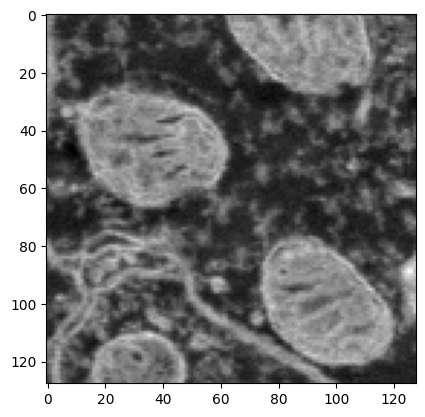

In [5]:
data = pd.read_csv('/content/gdrive/My Drive/DS5500/all_images_w_label.csv', header=None)
first_image = data.iloc[0, :-1].values
first_image = first_image.astype(np.uint8)

# Reshape the image to 128x128 and display it
first_image = first_image.reshape(128, 128)
print("label: ", data.iloc[0, -1])
plt.imshow(first_image, cmap='gray')
plt.show()

In [6]:
class FCNNModel(pl.LightningModule):
    def __init__(self):
        super(FCNNModel, self).__init__()
        self.layer_1 = nn.Linear(128 * 128, 128)
        self.layer_2 = nn.Linear(128, 64)
        self.layer_3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = F.relu(self.layer_1(x))
        x = F.relu(self.layer_2(x))
        x = F.softmax(self.layer_3(x), dim=1)
        return x

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log('val_loss', loss)


In [7]:

# Assuming 'data' is your DataFrame
X = data.iloc[:, :-1].values.reshape(-1, 128, 128) / 255.0  # Normalize pixel values
y = data.iloc[:, -1].values  # Labels

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train).float().unsqueeze(1)  # Add channel dimension
X_test_tensor = torch.tensor(X_test).float().unsqueeze(1)  # Add channel dimension
y_train_tensor = torch.tensor(y_train).long()
y_test_tensor = torch.tensor(y_test).long()

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)


In [8]:
# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [9]:
# Initialize TensorBoardLogger
logger = TensorBoardLogger("/content/gdrive/My Drive/DS5500/", name="fcnn_model_accuracy")

# Initialize our model
model = FCNNModel()

# Initialize a trainer
trainer = Trainer(max_epochs=10, enable_progress_bar=True, logger=logger, accelerator="gpu" if torch.cuda.is_available() else "cpu")

# Train the model
trainer.fit(model, train_loader, test_loader)



INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 2.1 M 
1 | layer_2 | Linear | 8.3 K 
2 | layer_3 | Linear | 650   
-----------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.425     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [10]:
!tensorboard --logdir fcnn_model_accuracy

2024-02-09 14:30:35.864518: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-09 14:30:35.864588: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-09 14:30:35.865984: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-09 14:30:37.278008: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to 

In [12]:
model.eval()

# Disable gradient computation for evaluation to save memory and computations
with torch.no_grad():
    correct = 0
    total = 0
    test_loss = 0
    loss_function = nn.CrossEntropyLoss()  # Assuming a classification problem

    for inputs, labels in test_loader:
        # Forward pass
        outputs = model(inputs)

        # Calculate loss
        loss = loss_function(outputs, labels)
        test_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate average loss and accuracy
test_loss /= len(test_loader.dataset)
test_accuracy = correct / total

print(f"MLP Test loss: {test_loss}")
print(f"MLP Test accuracy: {test_accuracy}")

MLP Test loss: 0.0464258301920361
MLP Test accuracy: 0.9966666666666667
